In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

import cv2

In [5]:
df_train = pd.read_csv("data/train.csv")

cl_type = dict(df_train.dtypes)
cl_type = {k:str(v) for k, v in cl_type.items()}
cl_type = [x for x in cl_type.keys() if cl_type[x] == 'int64']

In [6]:
df_train_sum_type = df_train.sum(axis=0)[cl_type]
df_train_sum_type = df_train_sum_type.sort_values(ascending=False)
df_train_sum_type = pd.DataFrame(df_train_sum_type, columns = ["count"])
df_train_sum_type = df_train_sum_type.reset_index()

colors = cm.hsv(np.linspace(0,1,len(df_train_sum_type), endpoint=False))
df_train_sum_type["color"] = df_train_sum_type.apply(
    lambda x: cm.hsv(x.name / len(df_train_sum_type)), axis=1
)

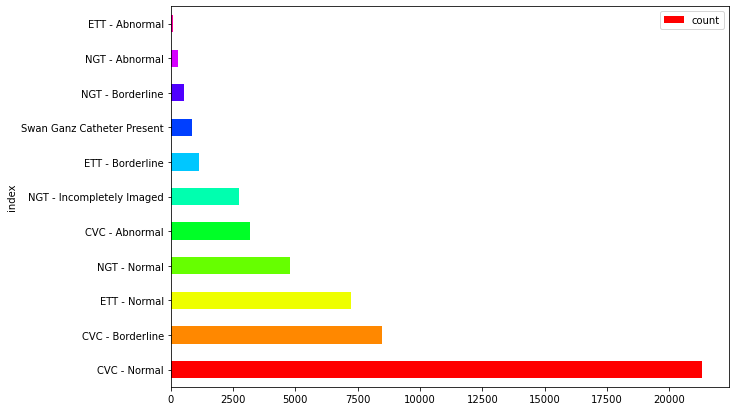

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

df_train_sum_type.plot.barh(x="index", y="count", ax=ax, color=df_train_sum_type["color"])
plt.show()

In [8]:
df_annot = pd.read_csv("data/train_annotations.csv")

df_annot_unique = pd.DataFrame(columns = ["StudyInstanceUID", "index_list"])
df_annot_unique["StudyInstanceUID"] = df_annot["StudyInstanceUID"].drop_duplicates()
df_annot_unique["index_list"] = df_annot_unique.apply(lambda x: list(df_annot.loc[df_annot["StudyInstanceUID"] == x["StudyInstanceUID"], ].index), axis=1)

In [9]:
def parse_array(data):
    data = data.replace("[", "").replace("]]", "]").split("], ")
    data = np.array([x.replace("]", "").split(", ") for x in data]).astype(int)
    return data

# df_annot row
def draw_singlerow(row, size=10, color=(255,0,0)):
    image = cv2.imread(f"data/train/{row['StudyInstanceUID']}.jpg")
    legend_items = [
        Line2D([0], [0], marker='o', color="w", label=row['label'], 
        markerfacecolor=(color[0]/255, color[1]/255, color[2]/255, 1.), markersize=8)]

    data = parse_array(row["data"])
    for point in data:
        image = cv2.circle(image, (point[0], point[1]), size, color, -1)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(row["StudyInstanceUID"])
    ax.legend(handles=legend_items)
    plt.show()

    return image

# df_annot_unique row
def draw_multirow(row):
    image = cv2.imread(f"data/train/{row['StudyInstanceUID']}.jpg")

    subset = df_annot.loc[row["index_list"]]
    for index, subrow in subset.iterrows():
        data = parse_array(subrow["data"])
        color = df_train_sum_type.loc[df_train_sum_type["index"] == subrow["label"], "color"].iloc[0]
        for point in data:
            image = cv2.circle(image, (point[0], point[1]), 10,
            (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)), -1)

    legend_items = []
    for label in subset["label"].drop_duplicates():
        color = df_train_sum_type.loc[df_train_sum_type["index"] == label, "color"].iloc[0]
        legend_items.append(
            Line2D([0], [0], marker='o', color="w", label=label, 
            markerfacecolor=(color[0], color[1], color[2], 1.), markersize=8))  

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(row["StudyInstanceUID"])
    ax.legend(handles=legend_items)
    plt.show()

    return image

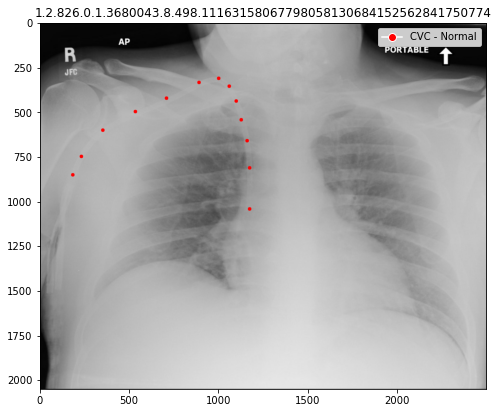

In [12]:
image = draw_multirow(df_annot_unique.iloc[20])

In [4]:
import argparse

parser = argparse.ArgumentParser(description="RANZCR Arguments")

dataset = parser.add_argument_group("dataset parameters")
dataset.add_argument("--file-loc", 
        default="data/train.csv", type=str,
        help="Path to training csv file")
dataset.add_argument("--image-size", 
        default=512, type=int,
        help="Output Image size")

args = parser.parse_args([])

In [8]:
args.to_str()

AttributeError: 'Namespace' object has no attribute 'to_str'